In [1]:
# Necessary imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# This line detects if we have a gpu support on our system
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
x1 = np.random.randn(2000)*0.5+3
x2 = np.random.randn(2000)*0.5+2

x3 = np.random.randn(2000) *0.5 + 4
x4 = np.random.randn(2000) *0.5 + 5

# Creating a Matrix
X_1 = np.vstack([x1, x2])
X_2 = np.vstack([x3, x4])
X = np.hstack([X_1, X_2]).T

# Creating a vector that contains classes (0, 1)
y = np.hstack([np.zeros(2000), np.ones(2000)])

print(X.shape)
print(y.shape)

(4000, 2)
(4000,)


Text(0, 0.5, 'feature 2')

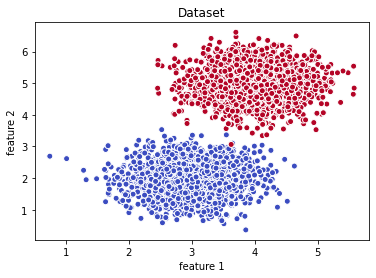

In [3]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=cm.coolwarm, edgecolors='w');
plt.title('Dataset')
plt.xlabel('feature 1')
plt.ylabel('feature 2')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# converting the datatypes from numpy array into tensors of type float
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)

y_train = torch.from_numpy(y_train.squeeze()).type(torch.FloatTensor).view(-1, 1)
y_test = torch.from_numpy(y_test.squeeze()).type(torch.FloatTensor).view(-1, 1)

# checking the shape
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([3200, 2])
torch.Size([800, 2])
torch.Size([3200, 1])
torch.Size([800, 1])


In [5]:
class ShallowNeuralNetwork(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(ShallowNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_num, hidden_num) # hidden layer
        self.output = nn.Linear(hidden_num, output_num) # output layer
        self.sigmoid = nn.Sigmoid() # sigmoid activation function
        self.relu = nn.ReLU() # relu activation function
    
    def forward(self, x):
        x = self.relu(self.hidden(x)) 
        out = self.output(x)
        return self.sigmoid(out)

input_num = 2
hidden_num = 2
output_num = 1 # The output should be the same as the number of classes

model = ShallowNeuralNetwork(input_num, hidden_num, output_num)
model.to(device) # send our model to gpu if available else cpu. 
print(model)

ShallowNeuralNetwork(
  (hidden): Linear(in_features=2, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)


In [6]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [7]:
if torch.cuda.is_available():
    X_train = Variable(X_train).cuda()
    y_train = Variable(y_train).cuda()
    X_test = Variable(X_test).cuda()
    y_test = Variable(y_test).cuda()

num_epochs = 1000

total_acc, total_loss = [], []

for epoch in range(num_epochs):
    # forward propagation
    model.train()

    y_pred = model(X_train)
    pred = np.where(y_pred > 0.5, 1, 0)
    loss = criterion(y_pred, y_train)
    
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
      model.eval()
      y_pred_test = model(X_test)

      test_loss = criterion(y_pred_test, y_test)
      total_loss.append(test_loss.item())

      total = 0
      pred = np.where(y_pred_test > 0.5, 1, 0)
      for i in range(len(y_test)):
        if int(y_test[i]) == int(pred[i]):
          total += 1
      
      acc = total / len(y_test)
      total_acc.append(acc)

      print('Epoch [{}/{}], Train Loss: {:.5f}, Test Loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, num_epochs, loss.item(), test_loss.item(), acc))
print('\nTraining Complete')

Epoch [0/1000], Train Loss: 0.71516, Test Loss: 0.70121, 0.52625
Epoch [50/1000], Train Loss: 0.56187, Test Loss: 0.57620, 0.52000
Epoch [100/1000], Train Loss: 0.30917, Test Loss: 0.32330, 0.95125
Epoch [150/1000], Train Loss: 0.18405, Test Loss: 0.19749, 0.97375
Epoch [200/1000], Train Loss: 0.13313, Test Loss: 0.14436, 0.97500
Epoch [250/1000], Train Loss: 0.10338, Test Loss: 0.11285, 0.97875
Epoch [300/1000], Train Loss: 0.08347, Test Loss: 0.09142, 0.98375
Epoch [350/1000], Train Loss: 0.06901, Test Loss: 0.07576, 0.98625
Epoch [400/1000], Train Loss: 0.05794, Test Loss: 0.06381, 0.99000
Epoch [450/1000], Train Loss: 0.04920, Test Loss: 0.05443, 0.99000
Epoch [500/1000], Train Loss: 0.04216, Test Loss: 0.04698, 0.99250
Epoch [550/1000], Train Loss: 0.03643, Test Loss: 0.04100, 0.99375
Epoch [600/1000], Train Loss: 0.03174, Test Loss: 0.03615, 0.99625
Epoch [650/1000], Train Loss: 0.02786, Test Loss: 0.03217, 0.99625
Epoch [700/1000], Train Loss: 0.02464, Test Loss: 0.02889, 0.9962

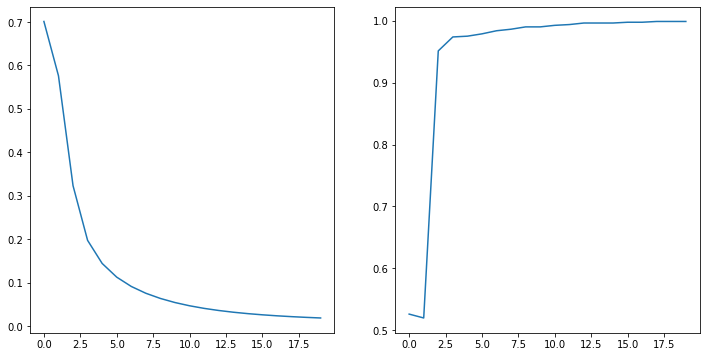

In [8]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1)
ax.plot(total_loss)

ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(total_acc)

In [67]:
model.eval()
model_prediction = model(X_test)

model_prediction = np.where(model_prediction > 0.5, 1, 0)
model_prediction = model_prediction.reshape(-1)

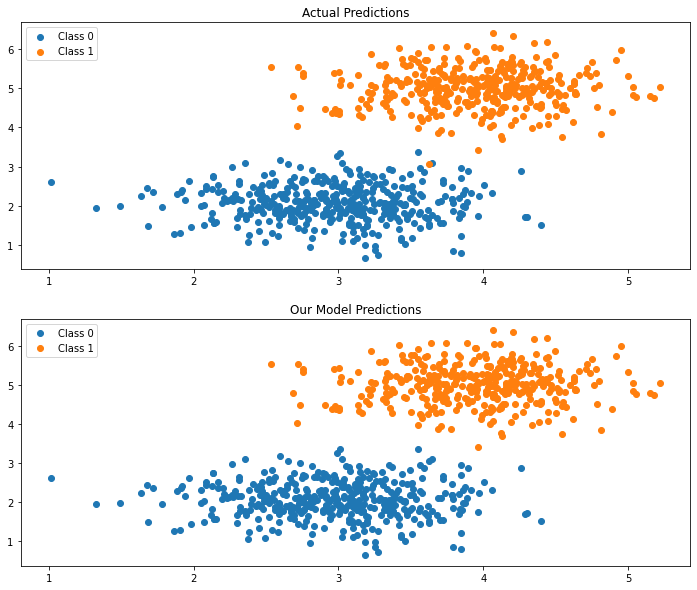

In [69]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
y_test = y_test.view(-1)

# True Predictions
ax[0].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='Class 0', cmap=cm.coolwarm)
ax[0].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='Class 1', cmap=cm.coolwarm)
ax[0].set_title('Actual Predictions')
ax[0].legend()

# Models Predictions
ax[1].scatter(X_test[model_prediction==0, 0], X_test[model_prediction==0, 1], label='Class 0', cmap=cm.coolwarm)
ax[1].scatter(X_test[model_prediction==1, 0], X_test[model_prediction==1, 1], label='Class 1', cmap=cm.coolwarm)
ax[1].set_title('Our Model Predictions')
ax[1].legend()